In [35]:
from sporco import util, signal, cnvrep
from sporco.admm import cbpdn, ccmod
from sporco.dictlrn import dictlrn
import numpy as np
from PIL import Image
import scipy.signal
import cv2
import glob

In [71]:
lmbda = 1.0
row = 256
col = 256
nbd = (15,15)
#画像の読み込み
normal_image = "image/train/TEST-R_WL-D-12222020113151-59.jpg"
anomalous_image = "image/NG0.jpg"
#anomalous_image  = normal_image
normal = np.asarray(Image.open(normal_image).convert('L'))
anomalous = np.asarray(Image.open(anomalous_image).convert("L"))

cv2.imwrite("NG.png",anomalous)

normal = np.asarray(Image.fromarray(normal).resize((row,col))).astype(np.float64).reshape((row,col,1))
anomalous = np.asarray(Image.fromarray(anomalous).resize((row,col))).astype(np.float64).reshape((row,col,1))

In [74]:
#低周波成分と高周波成分への分離
#あとでshapeを(row,col)に変える
normal_low, normal_high = signal.tikhonov_filter(normal, lmbda=10)
anomalous_low, anomalous_high = signal.tikhonov_filter(anomalous, lmbda=10)

In [8]:
#辞書の読み込み
dictionary=np.load("scripts/dictionary.npy")
#dictionary=np.random.rand(8,8,1,1,1)

In [9]:
def reconstruct_and_sparse_coding(dictionary,image):
    opt = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': 200,
                            'RelStopTol': 5e-3, 'AuxVarObj': False})
    sparse_coding = cbpdn.ConvBPDN(dictionary,image.astype(np.float64),lmbda=lmbda,opt=opt)
    
    #スパース表現を計算
    sparse_code = sparse_coding.solve()
    
    #画像再構成
    reconstructed = sparse_coding.reconstruct()
    
    #shapeをよしなに変換
    sparse_code = sparse_code.reshape((row,col,dictionary.shape[-1]))
    reconstructed = reconstructed.reshape((row,col))
    
    return sparse_code, reconstructed

In [10]:
def low_component_feature(image_low):
    image_low = image_low.reshape((row,col))
    num_of_pixels = nbd[0]*nbd[1]
    local_mean = cv2.blur(image_low,nbd)/num_of_pixels
    
    local_var = cv2.blur((image_low-local_mean)**2,nbd)/num_of_pixels
    
    return local_mean, local_var

In [11]:
def high_component_feature(image_high,sparse_code,reconstructed):
    image_high = image_high.reshape((row,col))
    reconstructed = reconstructed.reshape((row,col))
    
    #平均値フィルター
    filt = np.ones(nbd)
    #再構成誤差
    reconstruction_error=scipy.signal.convolve2d((reconstructed-image_high)**2,filt,mode="same")
    
    #スパースコードのL1norm
    L1norm = np.sum([scipy.signal.convolve2d(np.abs(sparse_code[:,:,i]),filt,mode="same") for i in range(sparse_code.shape[-1])],axis=0)
    
    #L2norm
    L2norm = np.sum([np.sqrt(scipy.signal.convolve2d(sparse_code[:,:,i]**2,filt,mode="same")) for i in range(sparse_code.shape[-1])],axis=0)
    
    return reconstruction_error, L1norm, L2norm 

In [12]:
normal_code,normal_reconstructed=reconstruct_and_sparse_coding(dictionary,normal_high)
anomalous_code,anomalous_reconstructed=reconstruct_and_sparse_coding(dictionary,anomalous_high)

Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  4.91e+06  4.66e+06  2.51e+05  4.32e-01  3.06e+01  5.10e+01
   1  1.07e+06  5.75e+05  4.90e+05  1.01e-01  8.96e+00  5.10e+01
   2  7.26e+05  1.45e+04  7.12e+05  3.57e-01  8.51e-01  1.23e+00
   3  2.05e+06  7.55e+03  2.04e+06  7.92e-01  3.93e-01  1.82e-01
   4  4.33e+06  4.68e+03  4.33e+06  8.84e-01  1.71e-01  5.88e-02
   5  6.44e+06  3.82e+03  6.44e+06  9.09e-01  9.37e-02  3.04e-02
   6  7.17e+06  3.46e+03  7.17e+06  9.03e-01  5.96e-02  2.15e-02
   7  6.47e+06  3.29e+03  6.47e+06  8.77e-01  4.57e-02  1.91e-02
   8  5.20e+06  3.25e+03  5.20e+06  8.36e-01  4.05e-02  1.91e-02
   9  4.18e+06  3.29e+03  4.17e+06  8.02e-01  3.86e-02  1.91e-02
  10  3.36e+06  3.38e+03  3.36e+06  7.71e-01  3.67e-02  1.91e-02
  11  2.73e+06  3.50e+03  2.72e+06  7.33e-01  3.37e-02  1.91e-02
  12  2.24e+06  3.61e+03  2.24e+06  6.76e-01  3.04e-02  1.91e-02
  13  1.87e+06  3.69e+03 

 126  3.61e+05  4.56e+03  3.56e+05  3.27e-02  1.46e-03  8.06e-03
 127  3.61e+05  4.57e+03  3.56e+05  3.25e-02  1.44e-03  8.06e-03
 128  3.60e+05  4.57e+03  3.56e+05  3.22e-02  1.42e-03  8.06e-03
 129  3.60e+05  4.58e+03  3.55e+05  3.19e-02  1.41e-03  8.06e-03
 130  3.60e+05  4.58e+03  3.55e+05  3.17e-02  1.39e-03  8.06e-03
 131  3.59e+05  4.59e+03  3.55e+05  3.14e-02  1.38e-03  8.06e-03
 132  3.59e+05  4.59e+03  3.54e+05  3.11e-02  1.37e-03  8.06e-03
 133  3.59e+05  4.59e+03  3.54e+05  3.09e-02  1.36e-03  8.06e-03
 134  3.58e+05  4.60e+03  3.54e+05  3.06e-02  1.35e-03  8.06e-03
 135  3.58e+05  4.60e+03  3.53e+05  3.04e-02  1.33e-03  8.06e-03
 136  3.58e+05  4.61e+03  3.53e+05  3.01e-02  1.32e-03  8.06e-03
 137  3.57e+05  4.61e+03  3.53e+05  2.99e-02  1.31e-03  8.06e-03
 138  3.57e+05  4.61e+03  3.52e+05  2.97e-02  1.30e-03  8.06e-03
 139  3.57e+05  4.62e+03  3.52e+05  2.94e-02  1.29e-03  8.06e-03
 140  3.56e+05  4.62e+03  3.52e+05  2.92e-02  1.27e-03  8.06e-03
 141  3.56e+05  4.63e+03 

  51  4.36e+05  4.11e+03  4.32e+05  8.46e-02  4.27e-03  6.83e-03
  52  4.33e+05  4.12e+03  4.29e+05  8.31e-02  4.21e-03  6.83e-03
  53  4.30e+05  4.13e+03  4.26e+05  8.16e-02  4.15e-03  6.83e-03
  54  4.28e+05  4.13e+03  4.24e+05  8.03e-02  4.07e-03  6.83e-03
  55  4.25e+05  4.14e+03  4.21e+05  7.91e-02  3.98e-03  6.83e-03
  56  4.23e+05  4.15e+03  4.19e+05  7.79e-02  3.87e-03  6.83e-03
  57  4.21e+05  4.15e+03  4.17e+05  7.68e-02  3.74e-03  6.83e-03
  58  4.20e+05  4.16e+03  4.16e+05  7.56e-02  3.62e-03  6.83e-03
  59  4.18e+05  4.17e+03  4.14e+05  7.44e-02  3.53e-03  6.83e-03
  60  4.16e+05  4.17e+03  4.12e+05  7.31e-02  3.47e-03  6.83e-03
  61  4.14e+05  4.18e+03  4.10e+05  7.18e-02  3.41e-03  6.83e-03
  62  4.12e+05  4.18e+03  4.08e+05  7.05e-02  3.36e-03  6.83e-03
  63  4.09e+05  4.19e+03  4.05e+05  6.92e-02  3.31e-03  6.83e-03
  64  4.07e+05  4.20e+03  4.03e+05  6.79e-02  3.25e-03  6.83e-03
  65  4.06e+05  4.20e+03  4.01e+05  6.67e-02  3.17e-03  6.83e-03
  66  4.04e+05  4.21e+03 

 179  3.41e+05  4.71e+03  3.36e+05  2.12e-02  9.89e-04  9.03e-03
 180  3.41e+05  4.72e+03  3.36e+05  2.10e-02  9.79e-04  9.03e-03
 181  3.41e+05  4.72e+03  3.36e+05  2.09e-02  9.69e-04  9.03e-03
 182  3.41e+05  4.72e+03  3.36e+05  2.08e-02  9.60e-04  9.03e-03
 183  3.41e+05  4.73e+03  3.36e+05  2.07e-02  9.52e-04  9.03e-03
 184  3.41e+05  4.73e+03  3.36e+05  2.06e-02  9.45e-04  9.03e-03
 185  3.40e+05  4.73e+03  3.36e+05  2.04e-02  9.39e-04  9.03e-03
 186  3.40e+05  4.74e+03  3.36e+05  2.03e-02  9.33e-04  9.03e-03
 187  3.40e+05  4.74e+03  3.35e+05  2.02e-02  9.26e-04  9.03e-03
 188  3.40e+05  4.74e+03  3.35e+05  2.01e-02  9.20e-04  9.03e-03
 189  3.40e+05  4.75e+03  3.35e+05  2.00e-02  9.15e-04  9.03e-03
 190  3.40e+05  4.75e+03  3.35e+05  1.99e-02  9.09e-04  9.03e-03
 191  3.39e+05  4.75e+03  3.35e+05  1.97e-02  9.01e-04  9.03e-03
 192  3.39e+05  4.76e+03  3.35e+05  1.96e-02  8.93e-04  9.03e-03
 193  3.39e+05  4.76e+03  3.34e+05  1.95e-02  8.86e-04  9.03e-03
 194  3.39e+05  4.76e+03 

In [13]:
np.mean(high_component_feature(normal_high,normal_code,normal_reconstructed)[2])

322.08250827379817

In [14]:
np.mean(high_component_feature(anomalous_high,anomalous_code,anomalous_reconstructed)[2])

313.71498620916526

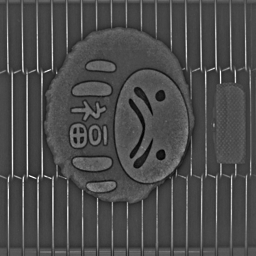

In [15]:
test = normal_reconstructed-np.min(normal_reconstructed)
test = 255*(test/np.max(test))
Image.fromarray(test.astype(np.uint8))

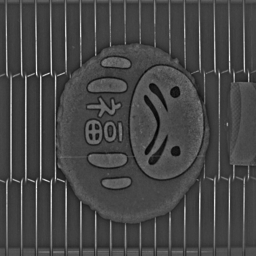

In [16]:
test = anomalous_reconstructed-np.min(anomalous_reconstructed)
test = 255*(test/np.max(test))
Image.fromarray(test.astype(np.uint8))

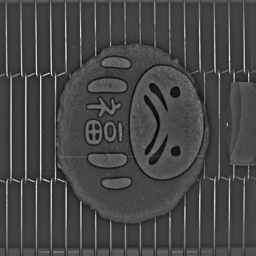

In [17]:
test = anomalous_high.reshape((row,col))-np.min(anomalous_high.reshape(row,col))
test = 255*(test/np.max(test))
Image.fromarray(test.astype(np.uint8))

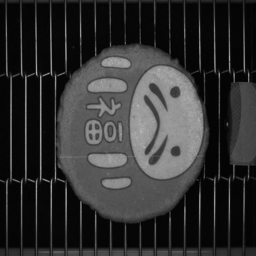

In [18]:
Image.fromarray(anomalous.reshape((row,col)).astype(np.uint8))

In [19]:
np.mean((normal_reconstructed-normal_high.reshape((row,col)))**2)

0.6632797871689369

In [20]:
np.mean((anomalous_reconstructed-anomalous_high.reshape((row,col)))**2)

0.6824210661625169

In [21]:
mean = np.load("scripts/mean.npy")
var = np.linalg.inv(np.load("scripts/var.npy"))

In [22]:
def Mahalanobis_dist(vector):
    return np.sqrt(((vector-mean).transpose()).dot(var.dot(vector-mean)))

In [23]:
hcl = high_component_feature(anomalous_high,anomalous_code,anomalous_reconstructed)
high = np.array([[[hcl[0][i][j],hcl[1][i][j],hcl[2][i][j]] for j in range(row)] for i in range(col)])

In [24]:
feature = [[list(high[x,y,:])+[low_component_feature(anomalous_low)[0][x][y],low_component_feature(anomalous_low)[1][x][y]] for y in range(col)] for x in range(row)]

In [25]:
feature = np.array(feature)

In [26]:
dist=[[Mahalanobis_dist(feature[i][j]) for j in range(row)] for i in range(row)]

In [33]:
gamma = np.sqrt(20)

In [34]:
dist = np.array(dist)
point=np.where(dist>gamma)

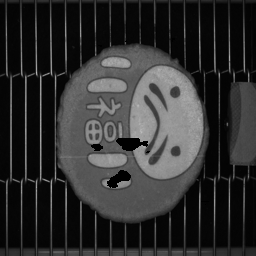

In [37]:
#anomalous = np.asarray(Image.open(anomalous_image).convert("L"))
#anomalous = np.asarray(Image.fromarray(anomalous).resize((row,col))).astype(np.float64).reshape((row,col,1))
point = np.where(dist>gamma)
marked = anomalous.reshape((row,col))
for i in range(len(point[0])):
    marked[point[1][i]][point[0][i]]=0

Image.fromarray(anomalous.reshape((row,col)).astype(np.uint8))

In [60]:
len(np.where(normal_code==0)[0])

1007062

In [40]:
np.mean(np.abs(normal_reconstructed-normal_high))

18.03986609379272

In [42]:
np.mean(np.abs(anomalous_reconstructed-anomalous_high))

17.944766418393932

In [75]:
atom0 = dictionary[:,:,0,0,2]
#atom1 = dictionary[:,:,0,0,1]

In [76]:
atom0 = atom0-np.min(atom0)
atom0 = 255*(atom0/np.max(atom0))

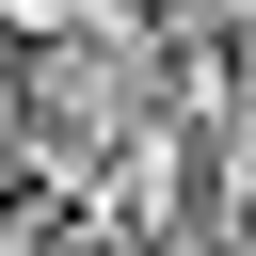

In [77]:
Image.fromarray(atom0.astype(np.uint8),mode='L').resize((row,col))

In [55]:
mean

array([1.57278922e+02, 1.04910075e+03, 3.28577411e+02, 2.14737124e-01,
       1.84768763e+01])

In [56]:
feature[0][0]

array([3.88726780e+01, 2.33352981e+02, 9.49001853e+01, 8.79143379e-02,
       1.80228456e+00])

In [57]:
var

array([[ 6.16024224e-04, -5.79239049e-05,  1.51342404e-04,
         1.48097097e-01, -7.19253158e-04],
       [-5.79239049e-05,  6.29077115e-05, -2.04688495e-04,
         4.19703077e-02, -2.88877337e-04],
       [ 1.51342404e-04, -2.04688495e-04,  7.24559939e-04,
        -1.34895651e-01,  9.48927007e-04],
       [ 1.48097097e-01,  4.19703077e-02, -1.34895651e-01,
         8.25036646e+02, -5.62229952e+00],
       [-7.19253158e-04, -2.88877337e-04,  9.48927007e-04,
        -5.62229952e+00,  3.99775447e-02]])

In [81]:
prob=0.04
gamma = np.sqrt(2/prob)
gamma=1000

In [88]:
np.where(dist==np.max(dist))

(array([129], dtype=int64), array([113], dtype=int64))

In [61]:
dictionary.shape

(16, 16, 1, 1, 16)

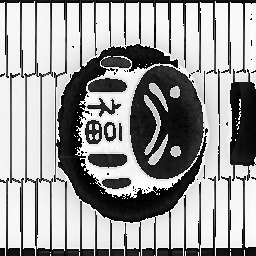

In [73]:
Image.fromarray(anomalous_high.astype(np.uint8).reshape((row,col)),mode='L')